![Fourier](https://tikz.net/files/fourier_series-011.png)

# <font color=#FFBB00> Fourier-Wavelet Tutorial </font>

In this tutorial we will explore the connection between a signal, its Fourier transform and its wavelet transform. The signal can be almost anything:
* weather,
* stock prices,
* elevation,
* EEG (brain waves),
* music,
* water surface waves,
* power consumption.

We will start with Fourier and then turn to wavelets. You can use this tutorial to understand either transform; but, an interesting goal is to **link the two transforms**. This is why both are in the same notebook: often you want to process a time series using both transforms and they should agree with each other in ways we will explore below.

The first question we need to deal with: why would we use a Fourier transform? It is the case that there are many, many reasons - far too many to discuss here. But, the reasons are as diverse as solving differential equations to denoising an electrical signal.

What is fundamentally important is that there exists _many_ transforms: we wish to understand why the Fourier transform is special. The reason is that we very often think in terms of frequencies. You almost certainly use the word "frequency" in your everyday life - you already know a bit about Fourier! Frequencies could be associated with other words you know, such as "notes" or "pitches". When we say that middle-C on a piano is tuned to 440Hz, we are making a statement about its Fourier properties. Other possible transforms don't have this strong connection to our thoughts, intuition and language.

What does it mean that something is a "transform"? In this context, a transform means we can take a function $f(t)$ and through an integral put it into a different space as $F(\omega)$. In this new space, called "Fourier space", the information is completely equivalent, but $F(\omega)$ tells us something about $f(t)$ we couldn't as readily see with $f(t)$ itself. (Note that this notation is completely arbitrary, as is the use of a 1D function for simplicity.)

Look at the picture at the top of this notebook.  Imagine the dark blue signal on the left is music - it represents the amplitude versus time. Maybe that is the electrical signal driving a speaker, for example. But, we have the question: what notes are the musicians playing? To determine the notes, we need to decompose the time series into specific frequencies, which is the same thing as saying "find the Fourier transform". Those notes, or frequencies, are shown as the pure sine waves along the frequency axes on the bottom right of the plot. How loud each note sounds is given by the amplitude of that sine function. Note that the units are **reciprocal**: in the figure, time is in seconds and the frequencies are in inverse seconds (also called Hertz or Hz).

Mathematically, how does all of this work? It's rather simple. First, we write the signal as
$$f(t)  = \int_{-\infty}^\infty \frac{d\omega}{2\pi}F(\omega) e^{i\omega t} .$$

Let's understand how this connects to what we learned above. First, some signals only use a discrete set of sinusoidal functions, as in the plot at the top of this notebook. This is because the signal is periodic. In general, however, we need to sum over a continuous set of frequencies (that is, all of them), and we get an _integral rather than a sum_. And, because there needs to be phase information among the sinusoidal components, we use the complex exponential $\exp(i\omega t)$ rather than sines and cosines (they are trivially related through the [Euler formula](https://en.wikipedia.org/wiki/Euler%27s_formula)). How much of each frequency is in the signal is given by $F(\omega)$: this is the Fourier transform we are looking for! To see the frequency content of a signal, we would plot $F(\omega)$ versus $\omega$.

While this formula is a great way to see how the signal $f(t)$ arises from the weighted sum/integral of sinusoids, how do we actually compute $F(\omega)$? Turns out that Fourier transforms have a very nice property that allows us to write the "inverse Fourier transform" as
$$F(\omega) = \int_{-\infty}^\infty dt\: f(t) e^{-i\omega t}.$$
As a homework problem, plug this into the first formula and prove that these are consistent. Clearly, we can go back and forth with these formulas:

![F_inv](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs40828-016-0037-1/MediaObjects/40828_2016_37_Fig9_HTML.gif)



If you have ever seen or used an equalizer, like this

![equal](https://www.lifewire.com/thmb/AgXtDZ_MiBjZYXQurE8HH9j7P-k=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-186591584-c4183cefc9684f72a9613e5f39e96bf6.jpg)

then you have seen $F(\omega)$, which is the height of the bars, each of which is at a discrete $\omega$.

_____

## <font color=#00BBFF> Numerical Issues with Fourier</font>

As we have seen, there is nothing too complicated about Fourier and, in fact, we "think in terms of Fourier" naturally. But, when we use the math and coding to solve real-world problem, there are a host of details that arise.

For example, if $t$ has units of hours, what are the units of $\omega$? And, should we use $\omega$, which is radians/time, or should we use $\nu = \omega/2\pi$? And, how is $\nu$ related to the period $T$? What are the units of $T$?

So far we have assumed that the signals are perfect mathematical functions. In the real world all functions are sampled at some $\Delta t$ for $N$ samples. This forces us to discretize the integrals given above. Because of this sampling, we can no longer control which frequencies we look at because:
* if we sample too infrequently ($\Delta t$ is too large), we can't resolve high frequencies
* if we don't sample long enough ($N$ is too small), we can't resolve low frequecies.

And, worse, if we use a library rather than code this ourselves, we need to get into the brain of the person who wrote the code because we don't know how they organized all of these issues. We can't simply take a $f(t)$, put it into an FFT library and hope to get a $F(\omega)$ that matches our goals: the library has no idea what our units of $t$ are; in fact, it doesn't even know that $t$ is a time variable - it could be spatial! For these reason, the burden is on us to keep track of the meaning, conventions and units of all variables.

None of this is hard, it's just something tedious we need to keep track of. But, the gain is that we get accurate and very fast Fourier transforms. (Most libraries use the FFT: [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform).)

Ok, let's bring in some obvious libraries and get to work!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import pywt

____

## <font color=#FF00BB> Creating Synthetic Data <font>

Next, we want to create a signal -- let's think of it as a time series -- that we can put in our own frequencies and then see if Fourier can find them for us.

This code allows us to build a time series of the form

$$f(t)  = \sum_n A_n \sin(2\pi \nu_n t + \phi_n) .$$

We get to pick the amplitude $A_n$, the frequency $\nu_n$ and phase $\phi_n$ of each component/note/frequency, and we can put in as many or as few as we wish. We will then only pass $f(t)$ to the Fourier routine to see if it can indeed tell us which frequencies are in our signal.

Before we build our signal, it is very important to pause and confirm that you know the units of all quantities in this equation. And, note that we could have also used $\omega_n = 2\pi\nu_n$; think about how that would change what we are looking for: do we expect Fourier to find $\omega_n$ or $\nu_n$?

Text(0.5, 1.0, 'Time Series')

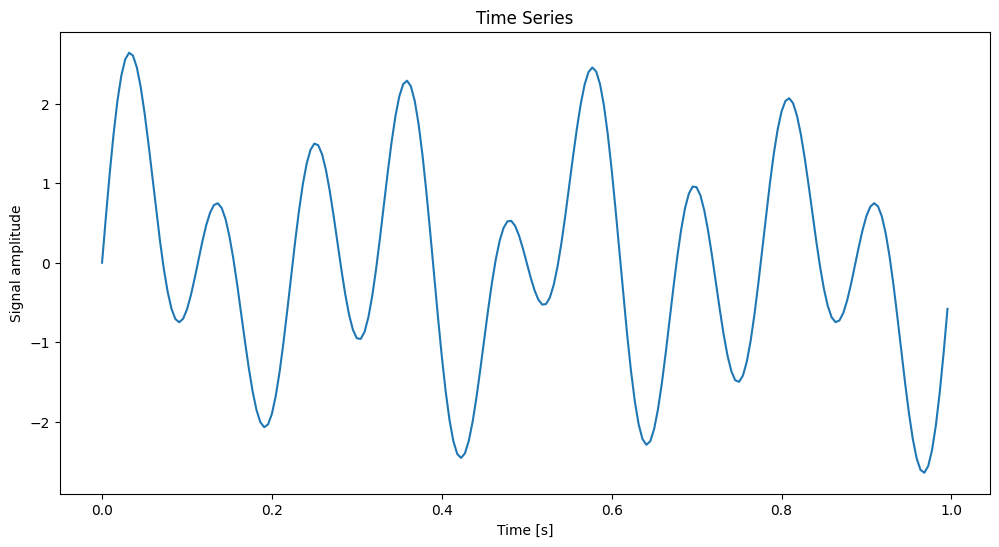

In [3]:
# vary these parameters and rerun to build your intuition

# parameters for sine functions
sine_params = [
    # (amplitude, frequency, phase); add more sine functions as needed
    (1.0, 4.0, 0.0),
    (0.5, 6.0, 0.0),
    (1.5, 9.0, 0.0)
]

# generate time series
num_time_points = 220
t = np.linspace(0, 1, num_time_points, False)  # assume units of seconds; note endpoint=False (why?)
timestep = t[1] - t[0]
signal = np.zeros_like(t)
for amplitude, frequency, phase in sine_params:
    signal += amplitude * np.sin(2 * np.pi * frequency * t + phase) # notice freq ν defined relative to 2π

# add noise
# signal += 0.01*np.random.randn(len(signal))

# visualize
plt.figure(figsize=(12, 6))
plt.plot(t, signal)
plt.xlabel('Time [s]')
plt.ylabel('Signal amplitude')
plt.title('Time Series')


It is important to see this signal the same way a computer does, so let's replot it.

Text(0.5, 1.0, 'What The Computer Sees')

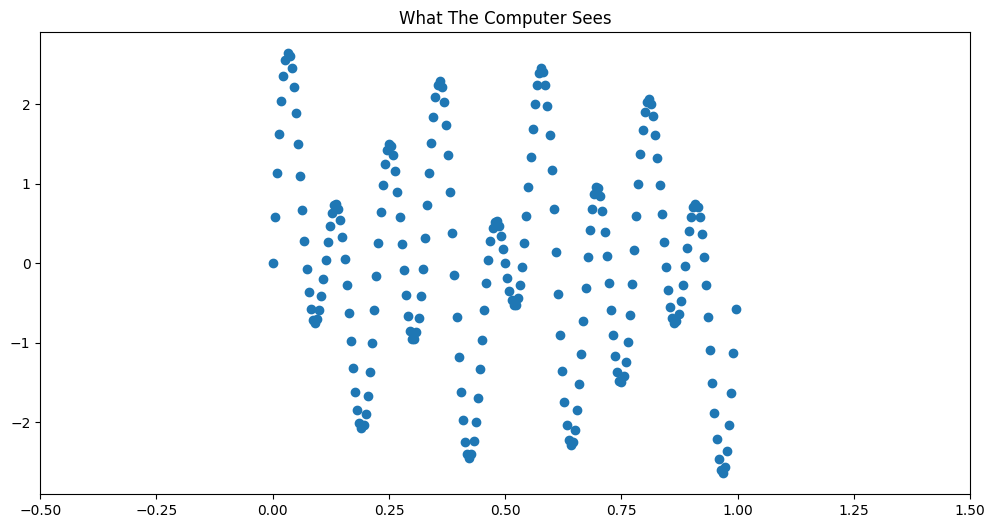

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(t, signal, 'o')
plt.xlim(-0.5, 1.5)
plt.title('What The Computer Sees')

Note that the computer only gets an array of points with no idea of what the axes are. That is, the computer only sees some array $x$ of length $N$ that can be indexed with $n$. The elements $x[n]$ contain the values of the signal (e.g., elevation, voltage, temperature, price), but there is no longer information about the integers $n$.

To see why this needs to be managed, note that the FFT library will return a second array $y$ with elements $y[k]$. Here, $k$ has something to do with the frequency; but, what does the integer $k=4$ mean? Since $k$ is just an index, has no units and we don't know how $y$ is ordered, it isn't clear what $y[k]$ is. We could certainly plot $y$ verus $k$, but we could not identify frequencies in real units. That is, if we see a peak in $y$, we can't know if that is a frequency of $1$Hz or $100$Hz. Luckily, most FFT (and wavelet) libraries come with helper functions that aid us in the necessary transformations.

The reason that libraries for Fourier are very stripped to their essentials is that they need to work on any dataset. The library has no idea what $x$ is, what the $n$ correspond to, or even what the units of these quantities are. By stripping away all of these details, the library applies to _any_ problem. For example, DFTs (discrete Fourier Transofrms) apply equally well to images:

![images](https://vincmazet.github.io/bip/_images/fourier-example.svg)

The downside to this generality is that you need to manage of the constants, conventions and units.

Too much talking! Let's look at some code.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Raw Fourier Spectrum')

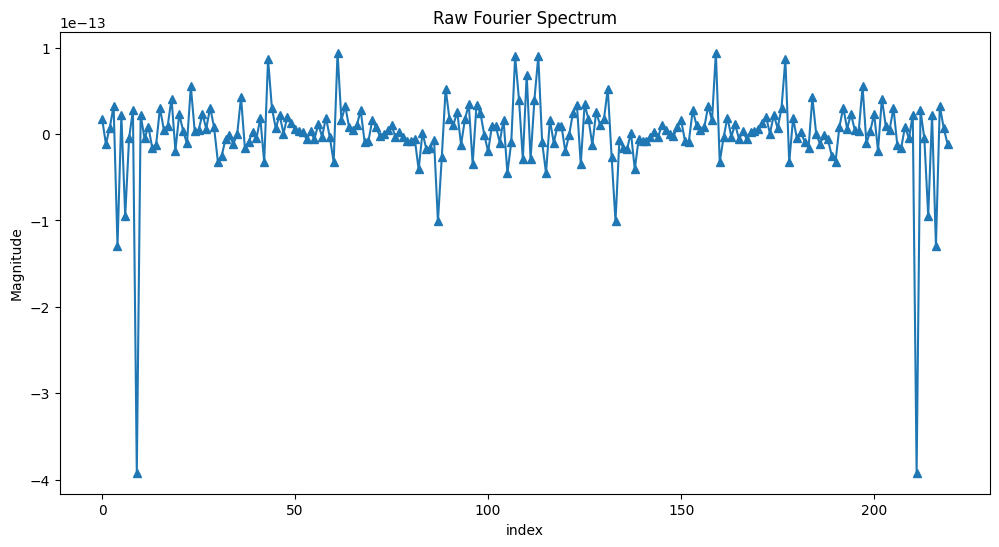

In [5]:
# raw version of FFT
yf = fft(signal) # note that the t array is not used!
plt.figure(figsize=(12, 6))
plt.plot(yf, '^-')
plt.xlabel('index')
plt.ylabel('Magnitude')
plt.title('Raw Fourier Spectrum')

Note that the FFT library only returns one array, which contains the magnitude - we don't yet know what frequencies these correspond to. And, also note that the spectrum "flips and repeats" in the middle of the array, not around a frequency of $0$ as we might have guessed. Finally, if you print the values returned, you will see that they are complex numbers.

How can we get to the Fourier spectrum we _actually desire_? There are three steps:
1. compute the frequencies,
2. place the zero frequency at the origin,
3. compute the magnitude of the complex values (if this is what we want).

What the math tells us:
* the maximum frequency is $N/2$
* the spacing $\Delta \nu$ is $1/(2\Delta t)$

From these we can compute an array of $\nu$ values. If we wanted to use angular frequencies $\omega$, these conversions would be modified. <font color=#BBBB00> These are the conversions we need so that the Fourier spectrum has peaks at the right locations in the right units</font>. We will have to do something similar to ensure that the bands in the wavelet diagram are at the right periods.

In [ ]:
# improved Fourier spectrum
yf = fft(signal)
# use information we know about the time values to find the frequency values
xf = np.linspace(0.0, 1.0/(2.0*timestep), len(t)//2) # // means floor division
plt.figure(figsize=(12, 6))
# convert to a real spectrum
plt.plot(xf, 2.0/len(t) * np.abs(yf[0:len(t)//2]))
plt.plot(xf, 2.0/len(t) * np.abs(yf[0:len(t)//2]), 'go', alpha=0.3)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')

We have created our own version of [this plot](https://en.wikipedia.org/wiki/Fast_Fourier_transform#/media/File:FFT_of_Cosine_Summation_Function.svg) from Wikipedia. Importantly, we have verified that the FFT procedure reproduces the  sinusoids we put into the signal and places a peak at the right location in the right units. Check to see that this agrees with the time series signal we created at the top of this notebook, vary it and re-run the notebook.

_____
### <font color=#BBFF00>Bit More Math</font>

At the beginning of this notebook we started with the common continuous Fourier transforms. We then moved conceptually to what is called the discrete Fourier transform (DFT), which is needed when we use a computer with real data, and we mentioned the fast Fourier transform (FFT), which is a fast algorithm almost always used in libraries. But, we didn't write the DFT/FFT equations. Let's take a look.

Using the [notation from NumPy](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft), we have:

$$A_k =\sum_{m=0}^{n-1} a_m \exp\left(-2\pi i\frac{mk}{n} \right); k=0,\ldots,n-1 ,$$
$$a_m =\frac{1}{n}\sum_{m=0}^{n-1} A_k \exp\left(2\pi i\frac{mk}{n} \right); m=0,\ldots,n-1 .$$

From the array $a_m$, the signal, we get the array $A_k$, which is the Fourier transform. Using the second expression, we get the inverse Fourier transform that reverses the process.

Importantly, note that these expressions are abstract and don't obviously correpsond to the integral forms given at the beginning of this notebook. It is up to the user to map their data, conventions and units onto these discrete sums. For example, $A[5]$ is the amplitude at some frequency; but, we can't know just from the these expressions what that frequency is or its units.

As mentioned above, the easiest way to handle this is to use helper functions. It is easy to work through the math once, but the helper functions are also there for a reason. Let's try this with [`fftfreq`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html).

Let's compare the frequencies we computed with NumPy:

In [7]:
print(np.fft.fftfreq(signal.size, d=timestep))
print(xf)

[   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.
   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.
   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.
   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.
   96.   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.
  108.  109. -110. -109. -108. -107. -106. -105. -104. -103. -102. -101.
 -100.  -99.  -98.  -97.  -96.  -95.  -94.  -93.  -92.  -91.  -90.  -89.
  -88.  -87.  -86.  -85.  -84.  -83.  -82.  -81.  -80.  -79.  -78.  -77.
  -76.  -75.  -74.  -73.  -72.  -71.  -70.  -69.  -68.  -67.  -66.  -65.
  -64.  -63.  -62.  -61.  -60.  -59.  -58.  -57.  -

';k____

### <font color=#00BBFF> Advice </font>

Don't trust your intuition, luck, guessing or the libraries. Whenever you need to perform an FFT, always verify your code by putting in a known signal and check to see that you get out exactly what you expect. Make sure the correct frequencies do appear, the units of frequency are correct, any conventions with $2\pi$ (radians versus Hz) are accounted and all plot choices are tuned. You can completely craft (e.g., frequenecy ranges, log or linear) your plots with fake data before using real, noisy data. Don't attempt to create your Fourier plot(s) with real data initially.

#### <font color=#FB00FB> Helper Functions </font>

As discussed in detial below, the most important issue, and often the only issue, is predicting what the frequencies are after the FFT in real values with real units. For this you want ['fftfreq`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html). Through its $d$ parameter, the spacing and units are set.

If you resampled and/or interpolated your data, you need to use the new $d$. And, importantly, the number of frequencies is $N/2$.
____

### <font color=#FFBB00> Math Summary </font>

Your time series starts at $t_1$, with a value $f(t_1)$, and ends at $t_2$, with a value $f(t_2)$. The time series is on a grid; if the grid is not uniform, it is usually more convenient to interpolate to make it uniform with some fixed $\Delta t$. You know what these values are and what units they are in: the computer has no idea.

Why? First, the computer never recieves any time information. FFT libraries only know that there are $N$ points. The library doesn't care that you start at $t_1$ in hours and the total length is $T = t_2-t_1$. In fact, it might be easier for you to just assume $t_1 = 0$ and $T=t_2$ because the FFT library can't tell the difference. The point is that you need to keep track of times and time intervals because the FFT library only knows $N$. Second, the library also does not know what $f(t)$ is or what units it is in. It only knows there is a set of values $\{f_1, f_2, \ldots, f_N\}$, where $f_n = f(n\Delta t)$. If you care about units, again, you need to keep track of them.

The main question is: given $\Delta t$ and $T$, what are $\Delta \nu$ and $\Omega$?

And, how are the FFT results organized?

The point is that you need to be cautious and not trust the library. Make good use of helper libraries that managage this and _always_ perhaps unit tests like the one above.

Some rules:
* FFT libraries usually work with frequencies $\nu$, not angular frequencies $\omega = 2\pi \nu$.
* $\Delta \nu = 1/T = \Omega/N$

Given $N$ and $T$, you can obtain $\Omega$ and $\Delta \nu$.

Ok, now you know how to assign frequencies to the results from the FFT and in the right units. Two other things to keep in mind:
* Recall that the FFT is usually a complex function, so you need to manage real and imaginary parts.
* What the FFT returns is two copies of length $N/2$, so you get redundant information. (This is a result of the sampling theorem.) You may need to sort/shift the values or use a helper library that does this for you. (And, different libraries may organize differently.)

Here is an example of using the complex values to get **magnitude** and **phase**, but ignoring units:
![mag_ph](https://pysdr.org/_images/fft-python5.png)

Here is another example of creating a test to be sure everything is working (getting the units right):
![tes](https://blog.mbedded.ninja/programming/signal-processing/fourier-transforms/1d-fourier-transform.png)

Here is an example showing another quantity -- the _spectral power_ -- of the signal, here using MHz as units:
![spec](https://i.stack.imgur.com/bzsiW.png)

Here is an example of a raw FFT that appears to be incorrectly shifted with unknown units, and notice there is rudundant information:

![shift](https://i.stack.imgur.com/x1MuJ.png)



_____

## <font color=#00BBFF> Numerical Issues with Wavelets</font>

Ok, let's now turn to wavelets and get them to work consistently with Fourier.

Wavelet transforms are yet another transform we can perform on a function. Unlike the Fourier transform, which is equivalent to expanding in a basis set composed of sines and cosines, there are many, _many_ wavelets. Here, we will focus on one wavelet transform: the [Morlet wavelet](https://en.wikipedia.org/wiki/Morlet_wavelet). This wavelet is the most closely related to Fourier and can be thought of an extension of it.

If you look at the equations for Fourier above, you see that the functions are multiplied by a sinusoidal function across the entire interval and integrated. While that is perfectly fine if that answers the question you are asking, what would we do if we want to see if the frequencies are shifting in our signal? For example, suppose the signal is music and we want to see if the notes/pitches are rising and/or falling. For example, what if we wanted to construct something like this?

![chirp](https://www.researchgate.net/publication/320967202/figure/fig12/AS:949146450153480@1603305556217/Spectrogram-of-the-wideband-LFM-chirp-signal-with-B-75-MHz.png)

Here, as you can see from the $y$ axis, the frequencies are shifting with time.We see that the pitch is rising. How would we make such a plot?

More important: what does it mean to have a range of frequencies at a given time?!

Intuitively, a very easy way to find the Fourier transform at different times is to break the signal into a few blocks and Fourier transform each block separately, which would yield a version of this plot but not as smooth. These sorts of tricks, of which there are many, are called "[windowed Fourier transforms](https://en.wikipedia.org/wiki/Window_function)" because there is a separate Fourier transform for each of several windows of the signal. An elegant, general and smooth way to solve this problem is to use the [Morlet wavelet](https://en.wikipedia.org/wiki/Morlet_wavelet). The Morlet wavelet $\psi$ is basically the complex exponential we saw in Fourier, but with a Gaussian envelope that localizes it to some scale:

![morlet](https://www.researchgate.net/publication/275068691/figure/fig1/AS:1088874885459969@1636619411142/Complex-Morlet-wavelet-function.jpg)

In general, a wavelet transform $F(\tau,s)$ of signal $f(t)$ has the form

$$F(\tau,s) = \frac{1}{|s|}\int_{-\infty}^\infty dt\: f(t)\: \psi^*\left(\frac{t-\tau}{s} \right) ,$$

where $\psi$ is the wavelet, $^*$ denotes complex conjugate and $s$ is the scale. Note that $F$ is a function of $2$ parameters: this shows that the wavelet indeed has more information than Fourier. Here, $\tau$ is the time axis (usually the $x$-axis) and it is the time we wish to find the frequency spectrum - see the figure above with the rising pitch. The other variable, $s$, is the scale, which can be seen to scale the wavelet; that is, $s$ determines how localized $\psi$ is. It would be natural to plot different values of $s$ on the $y$-axis, and some people do this; however, look at the plot above, which has frequency in MHz - perhaps we prefer to plot in some other units we choose? Or, perhaps we want the period, not the frequency? Again, there are choices that you need to make each of which corresponds to a set of conventions and units. What makes this more complicated is that the transform from period (or scale) to frequency is **non-linear**: you can't trivially just scale the axis labels, you have to compute them and place them yourself.

As with the Fourier transform, there is an inverse wavelet transform given by
$$f(t) = {\cal C} \int_{-\infty}^\infty \int_0^\infty d\tau ds\:F(\tau,s) \psi\left( \frac{t-\tau}{s}\right). $$

Here is an example where scale is used in units of months.
![scale](https://www.researchgate.net/publication/275407440/figure/fig2/AS:392021127778306@1470476528124/Continuous-wavelet-transform-CWT-of-monthly-rainfall-series-Standardized-time-series.png)

If we are only looking for qualitative information, using scale is perfectly fine. But, if we want to correlate the wavelet diagram with the Fourier spectrum, we need to convert to period and/or frequency and get the units right.

Note that there is a very clear horizontal band at about $12$ months, a constant frequency across all decades. Also, there are shorter horizontal bands that correspond to temporary frequencies. This is the easiest case to plot because we can simply use `pywavelets` and directly plot its output with `imshow`; this is because scale is the natural variable in the wavelet transform. But, to be more physical, we would prefer to plot in terms of the quantities period and frequency, and perferrably both.



_____

Let's write some code! To see the power of the wavelet transform we create a signal that has different frequencies at different times - this the super-power of wavelets. And, the most appropriate wavelet is the Morlet wavelet because it has the closest connection to the notion of "frequency".

This creates a new signal, which violates the purpose of the notebook! But, I wanted to make a signal with overalpping "notes". You can simply comment out a couple of lines and use the signal from above.

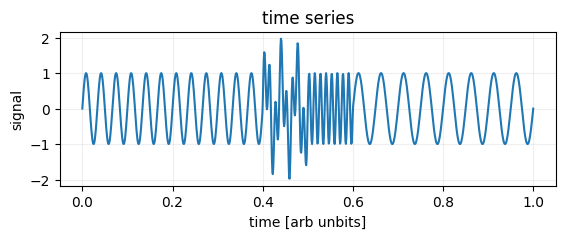

In [8]:
import pywt

# choose time time points
t = np.linspace(0,1, 1000)
# make a signal with different frequencies at different times
f = np.sin(2*np.pi*30*t)*(t<0.5) + np.sin(2*np.pi*80*t)*np.logical_and(t>=0.4, t<=0.6) + np.sin(2*np.pi*20*t)*(t>0.6)

# f = signal

# let's look at our creation
plt.figure(figsize=(6.4, 2))
plt.plot(t,f)
plt.ylabel("signal")
plt.xlabel("time [arb unbits]")
plt.title("time series")
plt.grid(alpha=0.2)

Note that there are four intervals with one of them having two frequencies present at the same time. You could think about this in terms of music: the frequencies are notes that can sometimes be played at the same time. Imagine that we want to take this signal, or a more complex one, and find the individual notes -- and how long they are being played.

Pause for a momentum and try to predict what the wavelet transform of this signal should look like. Don't worry - no one will know if you were incorrect the first time!

Next, let's just throw this at a library and and see what we get.

Text(0.5, 1.0, 'Fourier Spectrum')

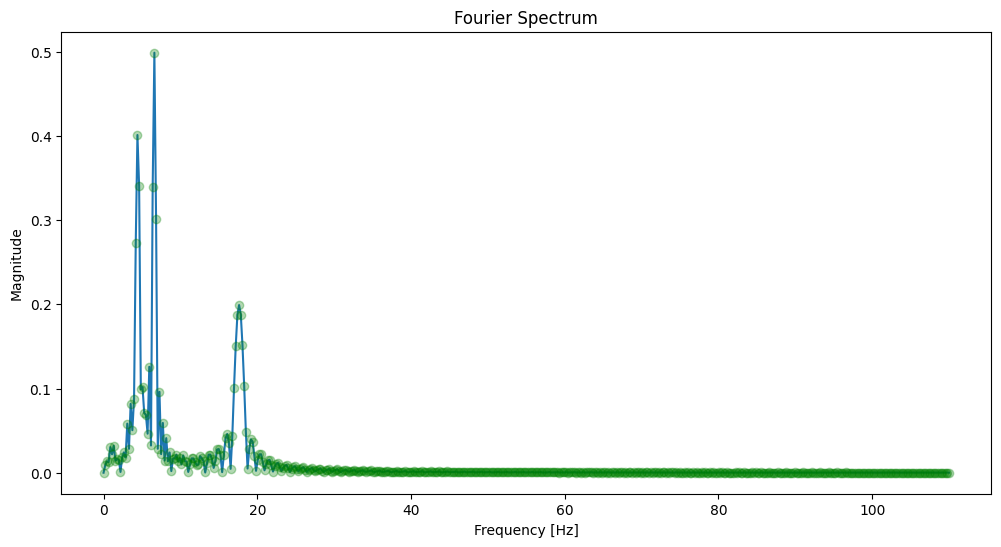

In [9]:
# improved Fourier spectrum
yf = fft(f)
# use information we know about the time values to find the frequency values
xf = np.linspace(0.0, 1.0/(2.0*timestep), len(t)//2) # // means floor division
plt.figure(figsize=(12, 6))
# convert to a real spectrum
plt.plot(xf, 2.0/len(t) * np.abs(yf[0:len(t)//2]))
plt.plot(xf, 2.0/len(t) * np.abs(yf[0:len(t)//2]), 'go', alpha=0.3)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')

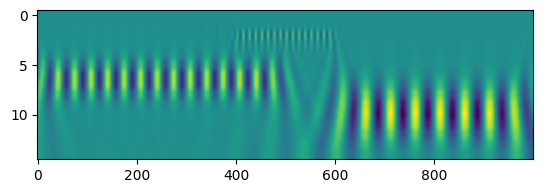

In [10]:
wavelet_name = 'morl'
scales = np.arange(1,60,4)
dt = t[1] - t[0]

[coefficients, frequencies] = pywt.cwt(f, scales, wavelet_name, dt)

plt.imshow(coefficients, aspect=20)

Beautiful! What we see is that there a band around $5$ on the left. At around $240$, a second band appears above that and continues to about $350$. Then, beyond about $350$ there is a lower band around $8$ that continues to the end.

Qualitatively, this shows exactly what we want: we see the three frequencies in our signal and when they are on and off.

This makes sense: we see the signature of the first frequency, then the second one gets added in, the first one stops while the second one stays on, then those two turn off and the final frequency is on. This is all great in the sense that we quickly got a wavelet diagram with little effort that we can begin to interpret.

As with the Fourier transform, the hard part is labeling the axes. The x-axis has nothing to do with the time points, which are $t \in [0,1]$, and the _higher_ frequencies are toward the _top_ of the diagram where the $y$-axis labels are _smaller_. We won't know what the labels or units are! (These are just row and column numbers, which is what `imshow` does by default, since it was designed for images originally.)

The module `imshow` has an option [`extent`](https://matplotlib.org/stable/tutorials/intermediate/imshow_extent.html) that allows us to place numbers on the axes. We can also set the origin, which is currently at the top by default.

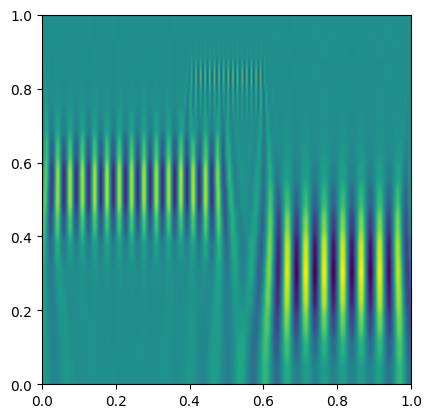

In [11]:
plt.imshow(coefficients, extent=[0,1, 0, 1], aspect=1)

We are part way there. The $x$-axis label is done: time runs from $0$ to $1$ linearly in this example, so we have the correct labeling on that axis. This is trival because we know the start time, the end time and that time progresses linearly. For the $y$ axis, we don't know any of this information.

The $y$ axis is more problematic. We first need to answer the question: what do we _want_ on that axis? At the moment, it's the scale $s$, which is the natural quantity for the wavelet transform. But, this does not convey much to our audience!

Now, you could argue that scale is a perfectly fine variable since it appears in the Morlet wavelet. This is true. If we wish to take this point of view, we need to do two things:
* ensure we know the range of scales - this is easy because we chose them (see the code above),
* use `extent` to place the min and max values in the proper places on the plot.

That works out well because we do know the min and max of the scales and they vary linearly (since we created them with `arange` or `linspace`). However, there are two other options:
* we don't create the scales linearly - since we pass them in, there is no reason to force them to be linear if we don't want them to be,
* we may want to plot some other variables, such as period or frequency, quantities much more familiar to our audience.

To truly understand this, consider the case where we create the scales with a list of values chosen randomly, as in $s=[5, 5.1, 7, 7.9, 11, 14, 34, 49.2341947]$, or perhaps on a log scale: how would we label the axis? The values corresponding to the rows are no longer linearly related and `extent` won't work, since it assumes a linear spread from the min to the max.

Frequency is a good choice for the label: people understand it and it is, in fact, how we specific our time series signal in the first place; it connects directly to Fourier!  What we could do is find the min and max frequency and simply put that into `extent`, right? **Wrong!!** The frequency is **not** linearly related to scale, as we can see in this plot.

Text(0, 0.5, 'scale')

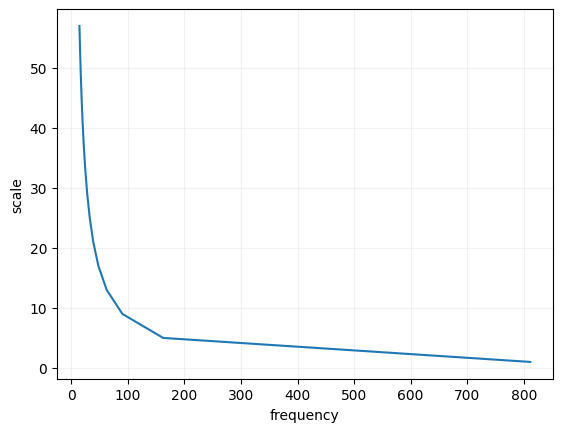

In [12]:
plt.plot(frequencies, scales)
plt.grid(alpha=0.17)
plt.xlabel("frequency")
plt.ylabel("scale")

We _could_ ask `extent` to put numbers on the $y$ corresponding to the min and max of the frequencies, but the spacing and distribution of frequencies in between would be _completely wrong_. A very small change of frequency at low frequencies is an enormous change of scale, and vice versa.

You might guess that using a log scale would repair this - it doesn't.

Also, we need not use `imshow`! I am just using that as an obvious way to plot the wavelet transform, but we could invent many other ways. Part of the issue here is that `imshow` has specific ways it represents the data.

_____

### <font color=#FFBB00> Numerical Issues with Wavelets</font>

Let's work through the math and set up some arrays. Ideally, let's make these choices:
1. we won't use scales because that is too tied to the Morlet wavelet, which the audience is not interested in,
2. the left $y$ axis is frequency, so that they can connect directly to the Fourier plots,
3. the right $y$ axis is period because that is very closely related to sampling times $\Delta$.

Let's think about it like this:
* we have a range of frequencies we wish to visualize over, perhaps by performing the FFT we did above,
* but, wavelets use scale, not frequency, and they are not trivally related,
* check to see if there is a helper function for this, since this feels like a common operation.

In this case, although This is very hard to find in the documentation, you can simply add an option to the call to the wavelets. If you look up above, this was done by adding the final argument `dt`. This tells the wavelet transform what your time step is; and, the results will be in the units of `dt`. So, if your time series is in, say, hours, then `dt = t[1]-t[0]` is in hours as well. The scales and frequencies can then be interpreted accordingly.

It is also possible to perform the conversions yourself or use `scale2frequency` and/or `frequency2scale`.  [Here](https://github.com/PyWavelets/pywt/issues/622) is a discussion of helper functions; in general, the documentation for PyWavelets is pretty bad. Because of this "mess", it is really good to use the approach here, which is to create known test functions and ensure everything works.

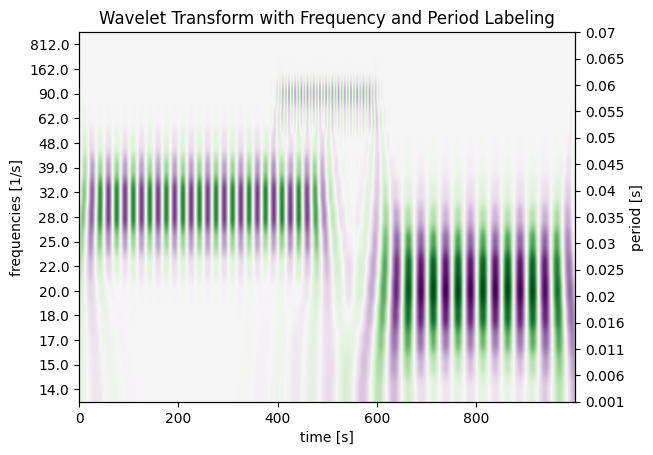

In [13]:
from math import floor

# prepare for using twin axes
fig, ax1 = plt.subplots()

# main plot
ax1.imshow(coefficients, cmap='PRGn',  aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

# labels for left axis
ax1.set_ylabel('frequencies [1/s]')
ax1.set_yticks(np.arange(coefficients.shape[0]), labels=np.round(frequencies))

ax1.set_xlabel('time [s]')
ax1.set_title('Wavelet Transform with Frequency and Period Labeling')

# add right axis with period
ax2 = ax1.twinx()

# labels for right axis
ax2.set_ylabel('period [s]')

# floor is used to get rid of excess decimal places
strs = [str(floor(p*1e3)/1e3) for p in 1/frequencies]
ax2.set_yticks(np.arange(coefficients.shape[0]), labels=strs) ;

Ok, we have achieved our goal: we have frequencies on the left axis and periods on the right axis and both are in the units of our time series.  This allows the reader to connect directly to Fourier (left axis) and to sampling $\Delta$ (right axis). This is a great test that all plots are labeled correctly and _consistently_.

Also, note that the frequencies are at the frequencies we set in our synthetic time series. Go back to the top, change the signal and ensure that all of the Fourier and wavelet plots update consistently. This is an opportunity to test the ideas and build intuition!

